In [31]:
import pickle
import os

FOLDER = os.getcwd() + "/3_ovals_noisy"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    original_psf = pickle.load(file)


In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import numpy as np
from scipy import fftpack
from utils import *

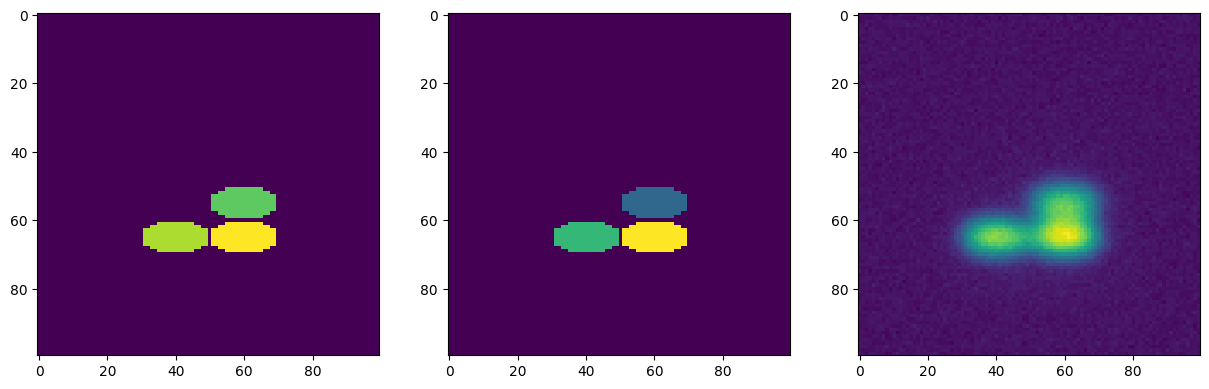

In [33]:
ori = ori/max(ori.flatten())
mask = mask/max(mask.flatten())
out = out/max(out.flatten())

f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

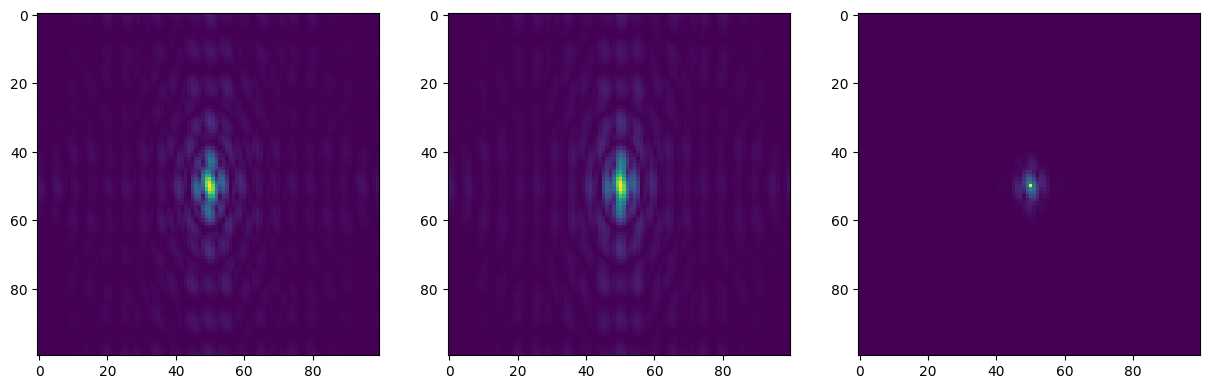

In [34]:
# Compute the 2d FFT of the input image
oriFreq = fftpack.fft2(ori)
maskFreq = fftpack.fft2(mask)
outFreq = fftpack.fft2(out)

# Shift the zero-frequency component to the center of the spectrum.
oriFreq = fftpack.fftshift(oriFreq)
maskFreq = fftpack.fftshift(maskFreq)
outFreq = fftpack.fftshift(outFreq)

f, axarr = plt.subplots(1,3)
axarr[0].imshow(np.abs(oriFreq))
axarr[1].imshow(np.abs(maskFreq))
axarr[2].imshow(np.abs(outFreq))
plt.show()

In [35]:
#Transform mask.shape into odd values

psfShape = [0,0]
psfShape[0] = mask.shape[0] + 1 if psfShape[0] % 2 == 0 else psfShape[0]
psfShape[1] = mask.shape[1] + 1 if psfShape[1] % 2 == 0 else psfShape[1]


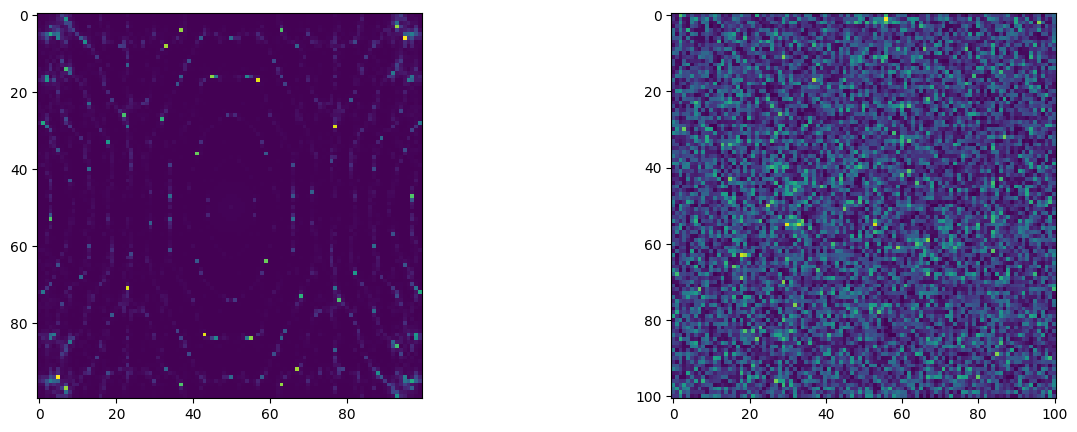

In [36]:
psfFreqIdeal = outFreq * np.conj(oriFreq) / (np.abs(oriFreq)**2 + 1e1/np.max(np.abs(oriFreq)**2))
psfIdeal = fftpack.ifft2(psfFreqIdeal,shape=psfShape)
psfIdeal = fftpack.fftshift(psfIdeal)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.abs(psfFreqIdeal))
axarr[1].imshow(np.abs(psfIdeal))
plt.show()

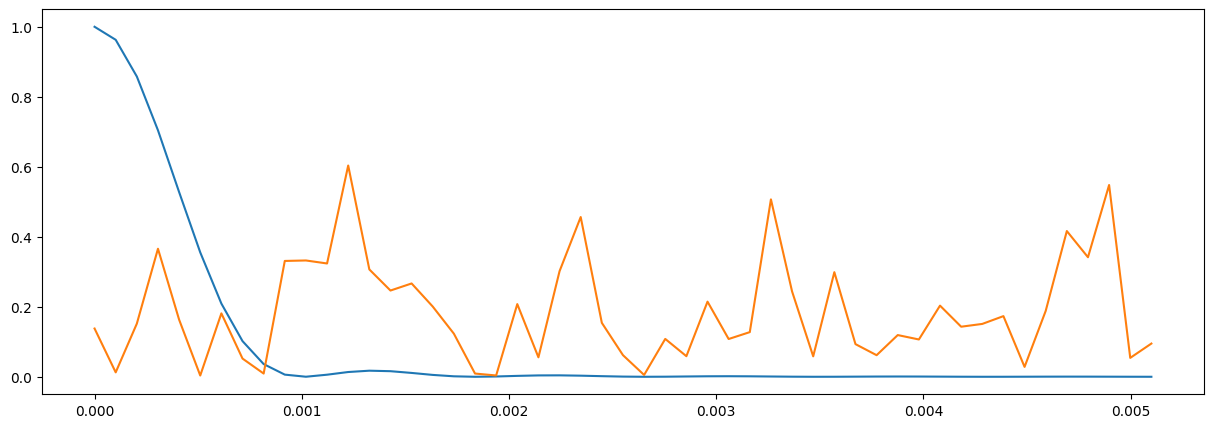

In [37]:
(maskWidth, maskHeight) = mask.shape
maskSize = maskWidth*maskHeight

#Normalise x axis of original psf to 1
original_psf_x = np.linspace(0,1,len(original_psf))*len(original_psf)/maskSize
original_psf_y = original_psf
plt.plot(original_psf_x,original_psf_y)

new_psf_y = np.abs(psfIdeal)
new_psf_y = new_psf_y/max(new_psf_y.flatten())
new_psf_y = new_psf_y[len(new_psf_y)//2]
new_psf_y = new_psf_y[len(new_psf_y)//2:]
new_psf_x = np.linspace(0,1,len(new_psf_y))*len(new_psf_y)/maskSize

plt.plot(new_psf_x,new_psf_y)
plt.show()


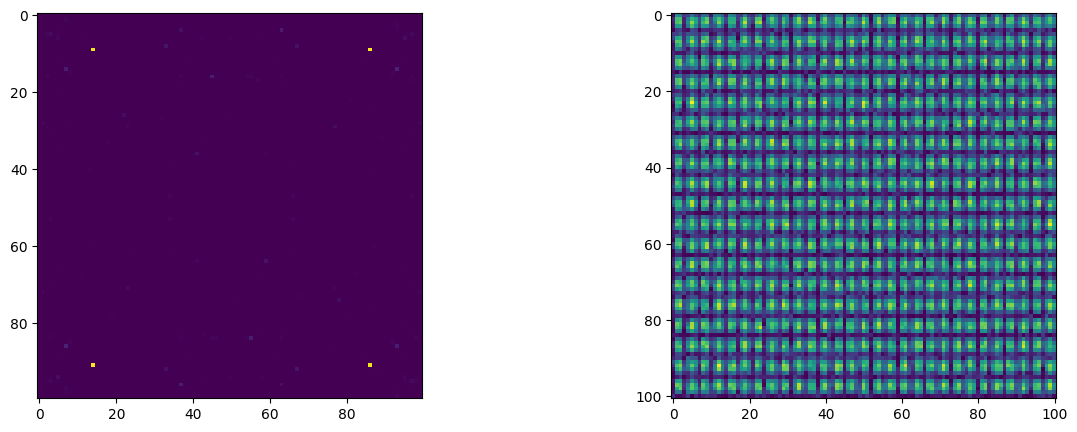

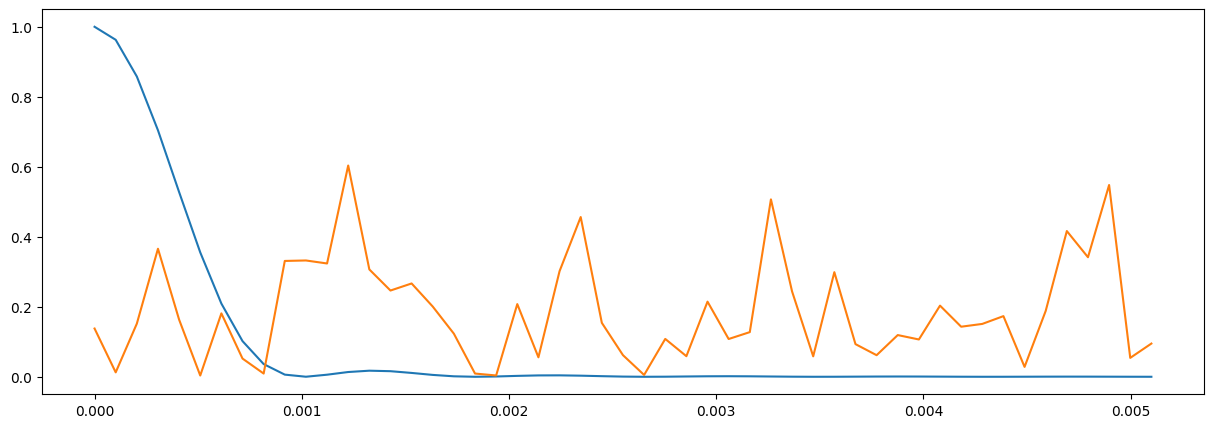

In [38]:

#We try to find psf with mask instead

psfFreq = outFreq * np.conj(maskFreq) / (np.abs(maskFreq)**2 + 1e-5/np.max(np.abs(maskFreq)**2))
psf = fftpack.ifft2(psfFreq, shape=psfShape)
psf = fftpack.fftshift(psf)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.abs(psfFreq))
axarr[1].imshow(np.abs(psf))
plt.show()

(maskWidth, maskHeight) = mask.shape
maskSize = maskWidth*maskHeight

#Normalise x axis of original psf to 1
original_psf_x = np.linspace(0,1,len(original_psf))*len(original_psf)/maskSize
original_psf_y = original_psf
plt.plot(original_psf_x,original_psf_y)

new_psf_y = np.abs(psfIdeal)
new_psf_y = new_psf_y/max(new_psf_y.flatten())
new_psf_y = new_psf_y[len(new_psf_y)//2]
new_psf_y = new_psf_y[len(new_psf_y)//2:]
new_psf_x = np.linspace(0,1,len(new_psf_y))*len(new_psf_y)/maskSize
plt.plot(new_psf_x,new_psf_y)
plt.show()

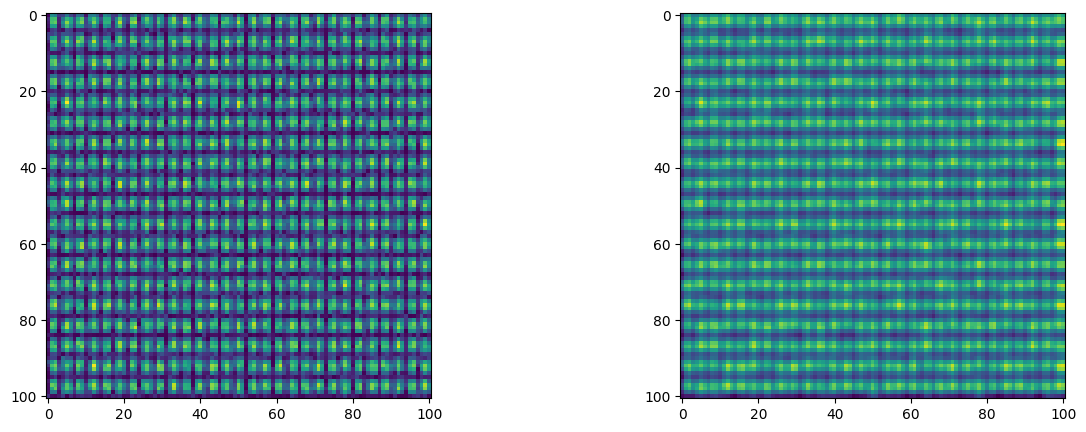

In [39]:
#Smooth psf with a gaussian filter

from scipy.ndimage import gaussian_filter
psfSmooth = gaussian_filter(np.abs(psf), sigma=1)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(np.abs(psf))
axarr[1].imshow(np.abs(psfSmooth))

[0.3333333333333333, 0.6666666666666666, 1.0]
[[-0.28441249]
 [-0.33356019]
 [ 1.        ]]


array([[1.        , 0.84931847],
       [0.84931847, 1.        ]])

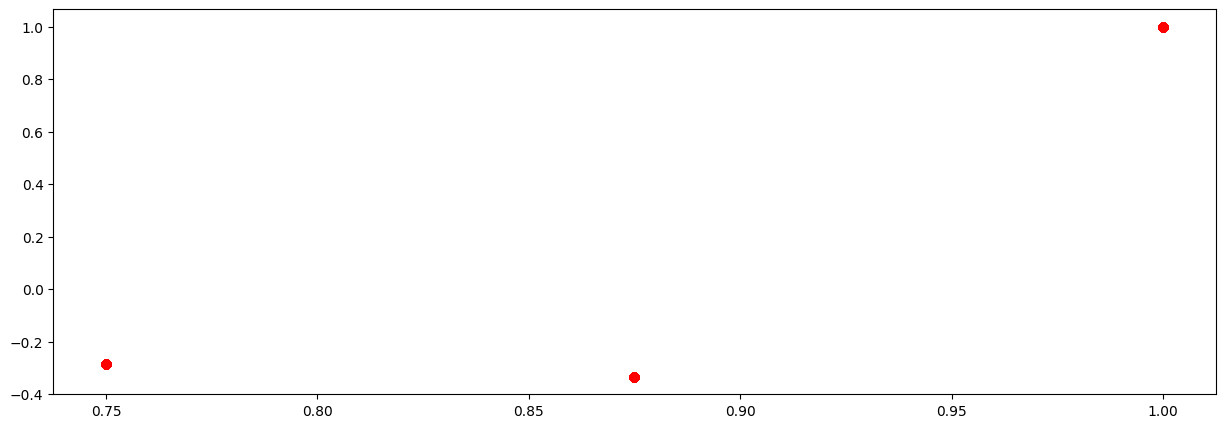

In [40]:
sourcePts = GetSourcePts(mask)
recoveredImage = InverseMatrix(out, mask, sourcePts, adjPts=5, learningRate = 1, psf=psfSmooth)

original_intensity = []
custom_intensity = []


for x in sourcePts:
    original_intensity.append(ori[x[0],x[1]])
    custom_intensity.append(recoveredImage[x[0],x[1]])

plt.plot(original_intensity,custom_intensity,'ro')

#Calculate correlation coefficient
np.corrcoef(original_intensity,custom_intensity)